<a href="https://colab.research.google.com/github/JaiswalFelipe/ITNPAI1_Assignment/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INITIAL

In [1]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Adjust figure sizes
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 100 

In [2]:
# Load data, Train, val, test split
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

X_val, y_val = X_train[:5000], y_train[:5000]
X_train, y_train = X_train[5000:20000], y_train[5000:20000]
X_test, y_test = X_test[:5000], y_test[:5000]

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Testing set size:", X_test.shape)

Training set size: (15000, 32, 32, 3)
Validation set size: (5000, 32, 32, 3)
Testing set size: (5000, 32, 32, 3)


# Image samples for each classes

In [3]:
# Creating and populating a dictionary to show random samples of images
class_dict = {"0": [],"1": [],"2": [],"3": [],"4": [],
              "5": [],"6": [],"7": [],"8": [],"9": []}

for i in range(len(X_train)):
  if y_train[i] == 0:
    class_dict["0"].append(X_train[i])
  elif y_train[i] == 1:
    class_dict["1"].append(X_train[i])
  elif y_train[i] == 2:
    class_dict["2"].append(X_train[i])
  elif y_train[i] == 3:
    class_dict["3"].append(X_train[i])
  elif y_train[i] == 4:
    class_dict["4"].append(X_train[i])
  elif y_train[i] == 5:
    class_dict["5"].append(X_train[i]) 
  elif y_train[i] == 6:
    class_dict["6"].append(X_train[i])
  elif y_train[i] == 7:
    class_dict["7"].append(X_train[i])
  elif y_train[i] == 8:
    class_dict["8"].append(X_train[i])
  elif y_train[i] == 9:
    class_dict["9"].append(X_train[i])

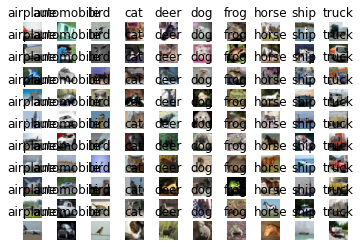

In [4]:
# Create a dict
class_dict_copy = class_dict.copy()

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

col = 0

f, axarr = plt.subplots(10,10)

for key in class_dict_copy:
  for i in range(0,10):
    img = random.choice(class_dict_copy[key])
    axarr[col, i].axis("off")
    axarr[col, i].title.set_text(classes[i])
    axarr[i, col].imshow(img)
  col += 1

# Data preparation

In [5]:
# Resize image function
def img_resize(data):
  resized_imgs = []
  for img in data:
    img = cv2.resize(img, (227, 227), interpolation=cv2.INTER_NEAREST)
    resized_imgs.append(img)

  return resized_imgs

In [6]:
training_data = img_resize(X_train)

In [ ]:
print(training_data[1])
#plt.imshow(training_data[1])

# Training

In [ ]:
#!pip install d2l==0.16.2 # Uncomment and run this if you are using Google Colab

In [ ]:
# AlexNet
#import tensorflow as tf
#from d2l import tensorflow as d2l

#def net():
#  return tf.keras.models.Sequential([
    # Here, we use a larger 11 x 11 window to capture objects. At the same
    # time, we use a stride of 4 to greatly reduce the height and width of
    # the output. Here, the number of output channels is much larger than
    # that in LeNet
#    tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4,

#    activation='relu'),
#    tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
    # Make the convolution window smaller, set padding to 2 for consistent
    # height and width across the input and output, and increase the
    # number of output channels
#    tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same',

#    activation='relu'),
#    tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
    # Use three successive convolutional layers and a smaller convolution
    # window. Except for the final convolutional layer, the number of

    # output channels is further increased. Pooling layers are not used to
    # reduce the height and width of input after the first two
    # convolutional layers
#    tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',

#    activation='relu'),

#    tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',

#   activation='relu'),

#    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',

#    activation='relu'),
#    tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
#    tf.keras.layers.Flatten(),
    # Here, the number of outputs of the fully-connected layer is several
    # times larger than that in LeNet. Use the dropout layer to mitigate
    # overfitting
#    tf.keras.layers.Dense(4096, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(4096, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
    # Output layer. Since we are using Fashion-MNIST, the number of
    # classes is 10, instead of 1000 as in the paper
#   tf.keras.layers.Dense(10)])


In [ ]:
class TrainCallback(tf.keras.callbacks.Callback): # Save
  """A callback to visiualize the training progress."""
  def __init__(self, net, train_iter, test_iter, num_epochs, device_name):
    self.timer = d2l.Timer()
    self.animator = d2l.Animator(
      xlabel='epoch', xlim=[1, num_epochs],
      legend=['train loss', 'train acc', 'test acc'])
    self.net = net
    self.train_iter = train_iter
    self.test_iter = test_iter
    self.num_epochs = num_epochs
    self.device_name = device_name

def on_epoch_begin(self, epoch, logs=None):
  self.timer.start()

def on_epoch_end(self, epoch, logs):
    self.timer.stop()
    test_acc = self.net.evaluate(self.test_iter, verbose=0,
    return_dict=True)['accuracy']
    
    metrics = (logs['loss'], logs['accuracy'], test_acc)
    self.animator.add(epoch + 1, metrics)
    if epoch == self.num_epochs - 1:
      batch_size = next(iter(self.train_iter))[0].shape[0]
      num_examples = batch_size * tf.data.experimental.cardinality(
      self.train_iter).numpy()
      print(f'loss {metrics[0]:.3f}, train acc {metrics[1]:.3f}, '
        f'test acc {metrics[2]:.3f}')
      print(f'{num_examples / self.timer.avg():.1f} examples/sec on '
        f'{str(self.device_name)}')

# Save
def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
  device_name = device._device_name
  strategy = tf.distribute.OneDeviceStrategy(device_name)
  with strategy.scope():
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    net = net_fn()
    net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  callback = TrainCallback(net, train_iter, test_iter, num_epochs,device_name)

  net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
  return net